<h1>Qiskit n-qubits GHZ state (extended Bell state)</h1>

In [1]:
# kernel extension for conditional cell execution
#
# set skip to True (%%skip True) in any block you want to skip

%reload_ext skip_extension

<h2>Step 0. Obtain the API_KEY from the .env file</h2>

In [2]:
from environs import Env
from IPython.display import display, Markdown

env = Env()

#env.read_env()                         # this does not work (?)
env.read_env('.env', recurse=False)     # read .env file, if it exists

token = env('IBM_QUANTUM_TOKEN')  

display(Markdown('<span style="color:red">>>> Token: ' + token[:5] + '...</span>'))     # Check that the starting characters of the token are printed

<span style="color:red">>>> Token: 4a7ea...</span>

<h2>Step 1.1. Create a circuit with n entangled qubits (GHZ state)</h2>

<span style="color:red">>>> Number of qubits in GHZ state: 10</span>

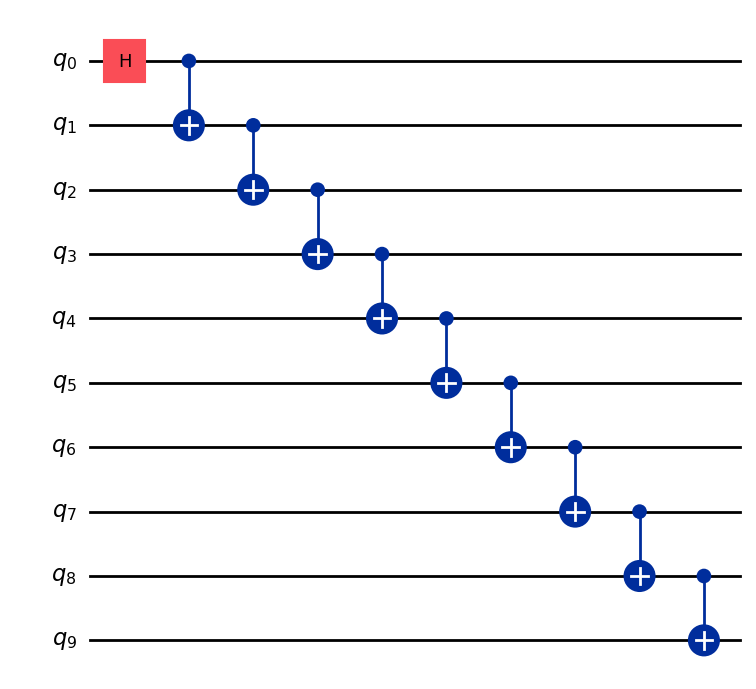

In [13]:
from qiskit import QuantumCircuit
 
def get_qc_for_n_qubit_GHZ_state(n: int) -> QuantumCircuit:
    """This function will create a qiskit.QuantumCircuit (qc) for an n-qubit GHZ state.
 
    Args:
        n (int): Number of qubits in the n-qubit GHZ state
 
    Returns:
        QuantumCircuit: Quantum circuit that generate the n-qubit GHZ state, assuming all qubits start in the 0 state
    """
    if isinstance(n, int) and n >= 2:
        qc = QuantumCircuit(n)
        qc.h(0)
        for i in range(n-1):
            qc.cx(i, i+1)
    else:
        raise Exception("n is not a valid input")
    return qc
 
# Create a new circuit with n qubits 

n = 10            # change this value for defining the size of the GZH state
                   #
                   # NOTE: Simulators are valuable for understanding small-scale QPUs, 
                   # but their usefulness maxes out at around 50 qubits, 
                   # even with access to high-performance supercomputers.
                   # The Qiskit simulator is able to handle circuits of up to 63 qubits,
                   # although these decompositions are approximate.
                   # For a large number of qubits, the only availabe option is QPU execution.
                   
display(Markdown('<span style="color:red">>>> Number of qubits in GHZ state: ' + str(n) + '</span>')) 

qc = get_qc_for_n_qubit_GHZ_state(n)

# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.
qc.draw("mpl")

<h2>Step 1.2. Set up a set of observables</h2>

In [14]:
from qiskit.quantum_info import SparsePauliOp

# Set up n qubit pairs observables: ZZII...II, ZIZI...II, ... , ZIII...IZ, and one additional ZZZ...ZZ
# for checking the correlation in Z between qubits.
# Increasing inaccurate (corrupted) expectation between distant qubits reveals the level of noise 

labels = ['Z' + 'I'*i + 'Z' + 'I'*(n-2-i) for i in range(n-1)]

labels.append('Z'*n)     # add correlation in Z between all qubits

display(Markdown('<span style="color:red">>>> "'+ str(len(labels)) + ' observables: ' +  str(labels)))
 
observables = [SparsePauliOp(operator) for operator in labels]


<span style="color:red">>>> "10 observables: ['ZZIIIIIIII', 'ZIZIIIIIII', 'ZIIZIIIIII', 'ZIIIZIIIII', 'ZIIIIZIIII', 'ZIIIIIZIII', 'ZIIIIIIZII', 'ZIIIIIIIZI', 'ZIIIIIIIIZ', 'ZZZZZZZZZZ']

<h2>Step 2.1.a. Set up backend for simulation</h2>

In [15]:
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2

display(Markdown('<span style="color:red">>>> NOTE: Simulators are valuable for understanding small-scale QPUs, but their usefulness makes out at around 50 qubits, even with access to high-performance supercomputers. The Qiskit simulator is able to handle circuits of up to 63 qubits, although these decompositions are approximate. For a large number of qubits, the only available option is QPU execution.</span>')) 

backend = FakeAlmadenV2()


<span style="color:red">>>> NOTE: Simulators are valuable for understanding small-scale QPUs, but their usefulness makes out at around 50 qubits, even with access to high-performance supercomputers. The Qiskit simulator is able to handle circuits of up to 63 qubits, although these decompositions are approximate. For a large number of qubits, the only available option is QPU execution.</span>

<h2>Step 2.1.b. Alternatively set up backend for hardware QPU</h2>

In [7]:
%%skip False      # set to True/False in order to skip/run this cell

display(Markdown('## <span style="color:red">>>>WARNING: *** No simulation. Next steps will run the circuit on hardware QPU ***</span>'))

from qiskit_ibm_runtime import QiskitRuntimeService

# If you did not previously save your credentials, use the following line instead:
# service = QiskitRuntimeService(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>")
service = QiskitRuntimeService(channel="ibm_quantum", token=token)

backend = service.least_busy(simulator=False, operational=True)


## <span style="color:red">>>>WARNING: *** No simulation. Next steps will run the circuit on hardware QPU ***</span>

<h2>Step 2.2. Convert to an ISA circuit layout</h2> 
<h3>(either for simulation or running on hardware QPU)</h3>

<span style="color:red">>>> Execution backend: fake_almaden</span>

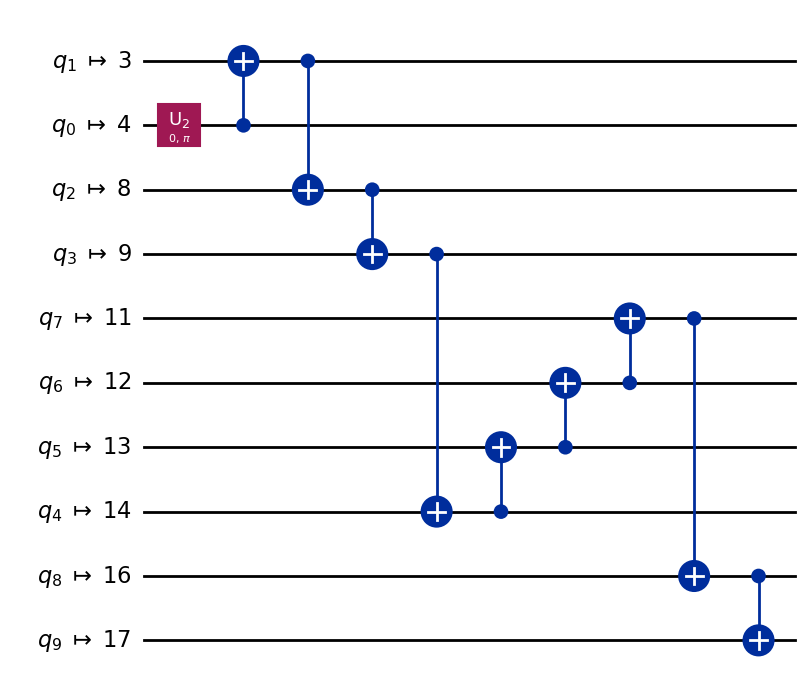

In [16]:
# Convert to an ISA circuit layout

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

display(Markdown('<span style="color:red">>>> Execution backend: ' + backend.backend_name + '</span>'))

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

isa_circuit.draw('mpl', idle_wires=False)       # draw cannot print a circuit with 100 qubits


<h2>Step 3'.1. Map the observables to the ISA circuit and construct the estimator instance</h2>

In [17]:
from qiskit_ibm_runtime import EstimatorOptions
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Map the observables to the ISA circuit

mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

# display(Markdown('<span style="color:red">>>> "Mapped observables: ' +  str(mapped_observables)))

options = EstimatorOptions()

options.resilience_level = 1                          # higher levels for more accurate results (but longer processing times)
options.dynamical_decoupling.enable = True            # reduce errors by dynamical decoupling 
options.dynamical_decoupling.sequence_type = "XY4"

# Construct the Estimator instance

estimator = Estimator(mode=backend, options=options)


<h2>Step 3'2. Run the circuit</h2>

In [18]:
%%skip False

job = estimator.run([(isa_circuit, mapped_observables)])

# Use the job ID to retrieve your job data later

job_id = job.job_id()

display(Markdown('<span style="color:red">>>> Save the job id for accessing the results when finished:<br>' +
                                         '>>> Job ID: ' + job_id + ' (' + str(job.status()) + ')</span>'))


c:\Users\canal\IBMQuantum\qiskitenv\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:186: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")
c:\Users\canal\IBMQuantum\qiskitenv\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


<span style="color:red">>>> Save the job id for accessing the results when finished:<br>>>> Job ID: 96816c99-62f5-4f3d-b75e-b0b1de6caab6 (JobStatus.RUNNING)</span>

<h2>Step 4.1. Retrieve a previously executed job</h2>
<h3>(only for execution on hardware QPU)</h3>

In [11]:

from qiskit_ibm_runtime import QiskitRuntimeService

# In order to fully recover your Job object, you need the job id.
# When the job is done, you can recover the Job object like this:

service = QiskitRuntimeService(channel="ibm_quantum", token=token)

job_id = 'cwh2628mptp00082rvwg'      # job_id from a previous execution on QPU (100-qubit GHZ state)
       # 'cwcfz4wggr6g008y4hp0'      # job_id from a previous execution on QPU (10-qubit GHZ state) with dynamical decoupling
       # 'cwcf7rfggr6g0082qkp0'      # same without dynamical decoupling

job = service.job(job_id)

<h2>Step 4.2. Show the results</h2>

<span style="color:red">>>> Job ID: 96816c99-62f5-4f3d-b75e-b0b1de6caab6</span>

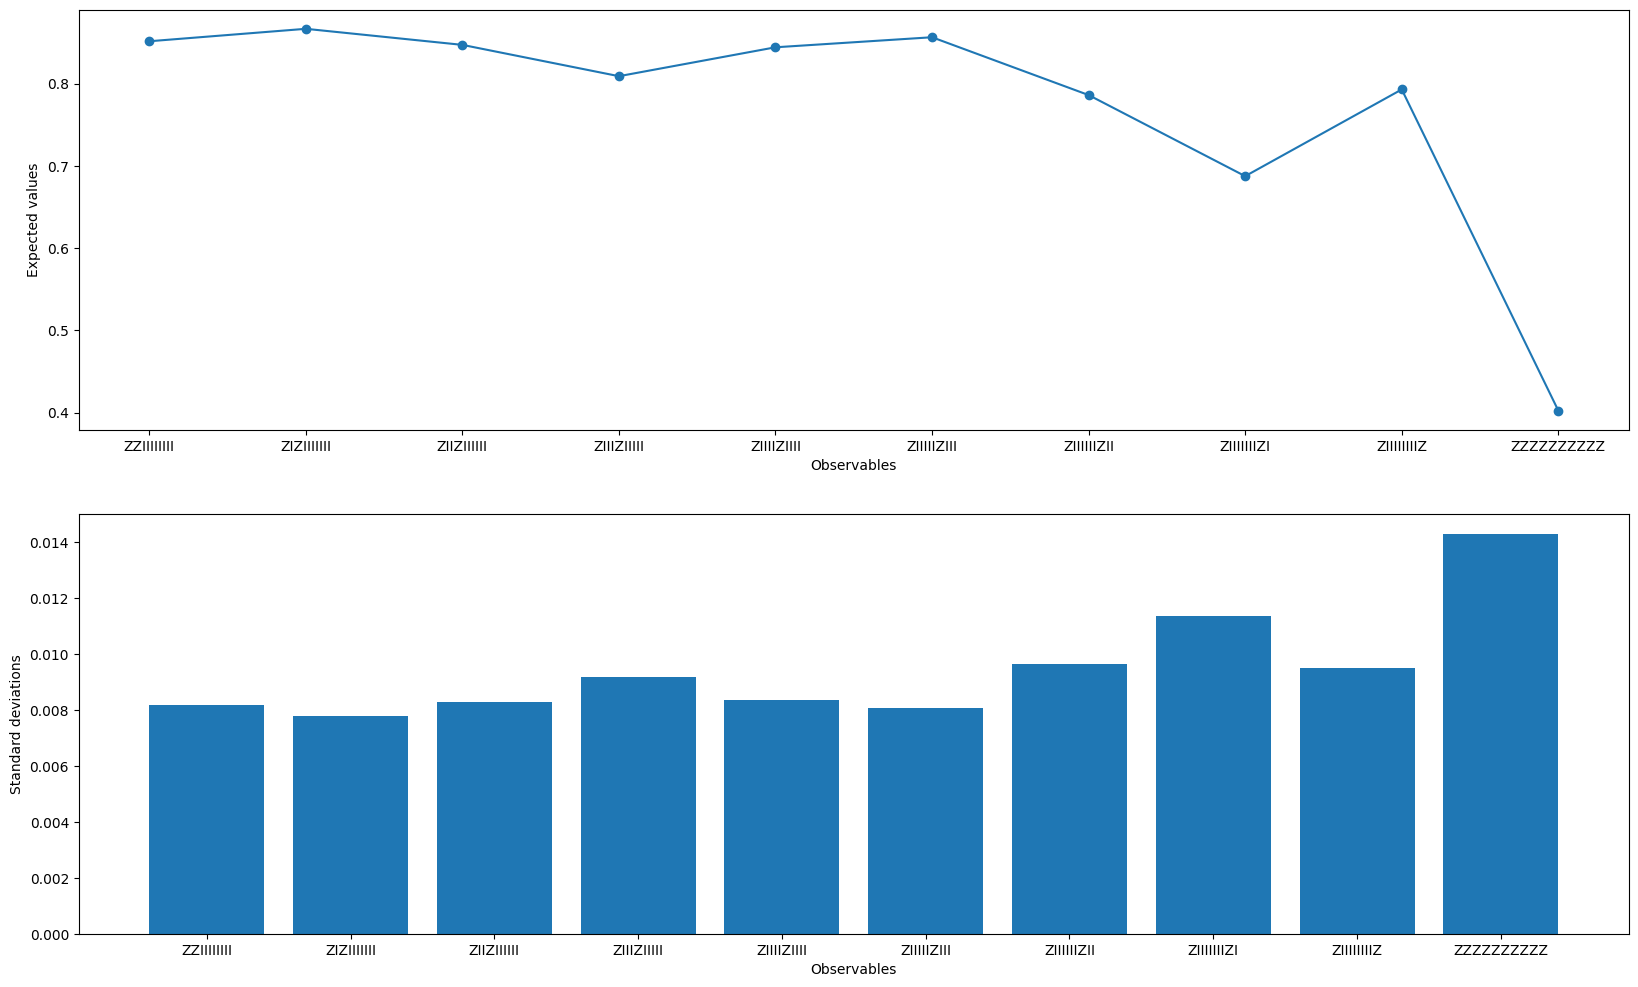

In [19]:

# Job for which we are showing the results.

display(Markdown('<span style="color:red">>>> Job ID: ' + job_id + '</span>'))


# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
 
job_result = job.result()
 
# This is the result from our single pub, which had five observables,
# so contains information on all five.
 
pub_result = job.result()[0]

# Plot the results
 
from matplotlib import pyplot as plt
 
values = pub_result.data.evs
 
errors = pub_result.data.stds

# plotting graphs of values and errors

plt.rcParams["figure.figsize"] = (20,12)

plt.subplot(2,1,1)  # 2 rows, 1 column; this is the first plot
plt.plot(labels, values, '-o')
# plt.bar(labels, values)
plt.xlabel('Observables')
plt.ylabel('Expected values')

plt.subplot(2,1,2) # 2 row, 1 columns; this is the second plot 
# plt.plot(labels, errors, '-o')
plt.bar(labels, errors)
plt.xlabel('Observables')
plt.ylabel('Standard deviations')

plt.show()